<a href="https://colab.research.google.com/github/Shifana2003/Naan-mudhalvan-projects/blob/main/Copy_of_Apple_stock_price_prediction_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'stock-price-prediction-of-apple-inc:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1668559%2F2736918%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240430%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240430T042820Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2a1403d78d06b27b900b80d6f53e0154aa29d6f84303dea265763aab4f061277cd15d39bd801565306f54e25aa73d6d8cd236fd164e47b16c68d723dc6672f7adbe58f8b90d4e15f65b530ad80833b809e404431d65c05cad04b13f2a6b4ecdc9821f2ba71efd6e3469db45817b8833ab30dfc5b69ba2ffded5caba02166396f1eaca28d96b4ebfec7c5cdf2e46a8ec562dc0c355f8ed74ea779810f5987d148bcc93da9fce16b4d0a63014218cf6dec73d528ebe60b97112d83767c9b0addf987d8f88a3ae970c107c18c2da79c54d18e606a319606f0610b102dfa37eeba3e412ce7ac7afcf24053e0b48b0b08f36fb1e620f1eff9bc9248390018e078d7a1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 29349 bytes downloaded
Downloaded and uncompressed: stock-price-prediction-of-apple-inc
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-price-prediction-of-apple-inc/apple_share_price.csv


In [7]:
import pandas as pd
import numpy as np
from numpy import array
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
%matplotlib inline

In [3]:
df=pd.read_csv('../input/stock-price-prediction-of-apple-inc/apple_share_price.csv')
df.head()

,Date,Open,High,Low,Close,Volume
0,11-Aug-17,156.60,158.57,156.07,157.48,26257096
1,10-Aug-17,159.90,160.00,154.63,155.32,40804273
2,9-Aug-17,159.26,161.27,159.11,161.06,26131530
3,8-Aug-17,158.60,161.83,158.27,160.08,36205896
4,7-Aug-17,157.06,158.92,156.67,158.81,21870321


In [4]:
df.shape

(1664, 6)

In [9]:
df1=df.reset_index()['Close'];df1

0       157.48
1       155.32
2       161.06
3       160.08
4       158.81
         ...  
1659     48.02
1660     47.68
1661     47.71
1662     47.33
1663     47.08
Name: Close, Length: 1664, dtype: float64

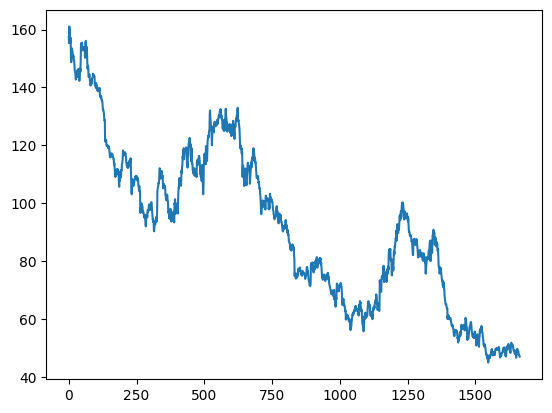

In [10]:
plt.plot(df1);plt.show()

In [11]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1));df1

array([[0.96914059],
       [0.95052151],
       [1.        ],
       ...,
       [0.02292906],
       [0.01965348],
       [0.01749849]])

In [12]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
print(training_size,test_size)

1081 583


In [13]:
#convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [14]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [15]:
print(X_train.shape), print(y_train.shape),print(X_test.shape), print(ytest.shape)

(980, 100)
(980,)
(482, 100)
(482,)


(None, None, None, None)

In [16]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [17]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
history=model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=0)

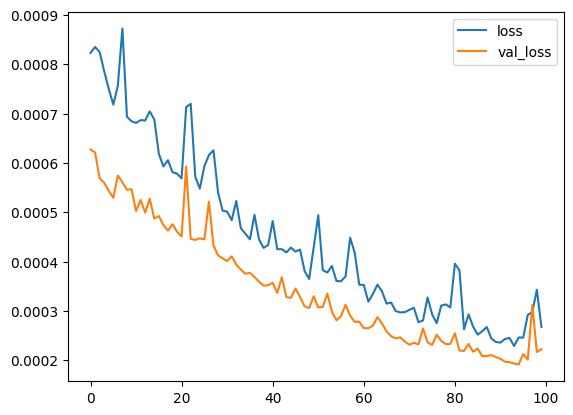

In [20]:
# Show the learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();


In [21]:
train_predict=model.predict(X_train) #prediction
test_predict=model.predict(X_test)

16/16 [==============================] - 1s 34ms/step


In [22]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [23]:
#Calculate RMSE performance metrics
from sklearn.metrics import mean_squared_error
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(ytest,test_predict)))

103.14049442932959
69.4164778535983


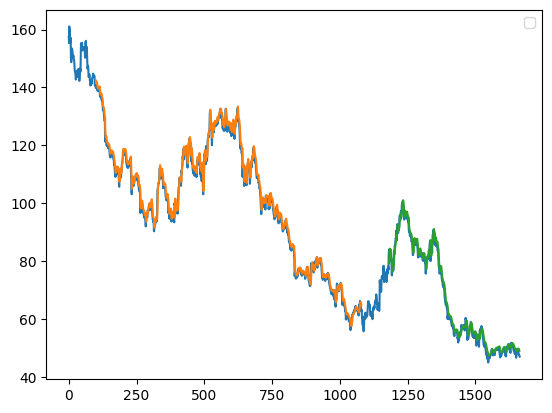

In [24]:
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend()
plt.show()

In [25]:
x_input=test_data[483:].reshape(1,-1) #len(test_data)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [26]:
# demonstrate prediction for next 10 days
lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[0.03042993]
101
1 day input [0.02077407 0.02344625 0.02448065 0.03103181 0.03016981 0.02560124
 0.02206706 0.03094561 0.03844496 0.03922076 0.04197914 0.03973795
 0.03853116 0.03870356 0.04215154 0.04042755 0.03810016 0.04284113
 0.03870356 0.04284113 0.04318593 0.04637531 0.04353073 0.03335919
 0.02775623 0.02034307 0.01491251 0.02103267 0.02560124 0.02103267
 0.01905008 0.02430825 0.02801483 0.02792863 0.02896302 0.0318076
 0.03594518 0.04085855 0.04094475 0.04387553 0.04318593 0.04456512
 0.03646237 0.02939402 0.0318076  0.02948022 0.01887768 0.02379105
 0.01801569 0.03706577 0.04706491 0.04508232 0.03853116 0.04568572
 0.04973709 0.04930609 0.05499526 0.05447806 0.04525472 0.04180674
 0.04663391 0.04042755 0.03387639 0.03361779 0.02861822 0.04335833
 0.05292647 0.05887423 0.05482286 0.05396087 0.05111628 0.0482717
 0.05275407 0.0490475  0.04499612 0.03835876 0.03456599 0.03568658
 0.03654857 0.02948022 0.02551504 0.03430739 0.03508318 0.0320662
 0.02723903 0.01396431 0.02137747 0.

In [27]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

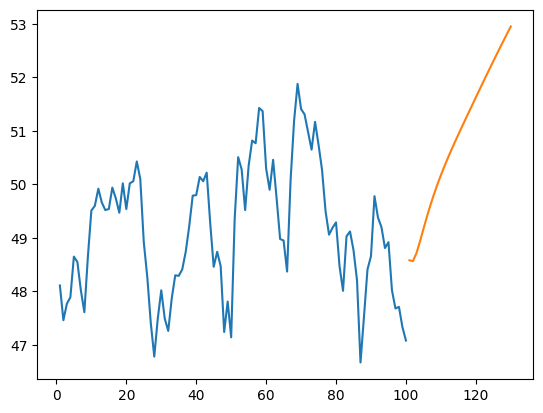

In [28]:
plt.plot(day_new,scaler.inverse_transform(df1[1564:])) #len(df1)
plt.plot(day_pred,scaler.inverse_transform(lst_output))

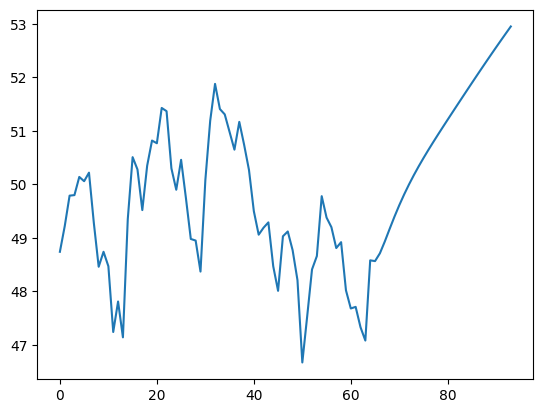

In [29]:
df3=df1.tolist()
df3.extend(lst_output)
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3[1600:])

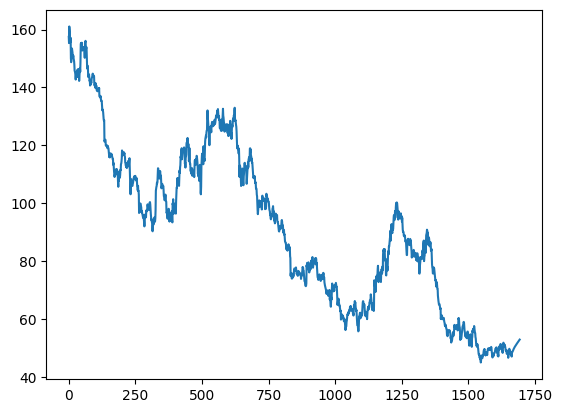

In [30]:
plt.plot(df3)